In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import argparse
import csv
import os
import json
import sys
import pickle
import numpy as np
import pandas as pd
from os.path import join
from collections import defaultdict, deque
import itertools

###  Basically we took two different approach to this problem
### 1) Confuse the agent, "Tough Love": 

randomizes (random conv or random crop) the pixel input to add noise to agent's observations, so that it's "forced" to learn generalizable representations instead of falsely correlating irrelevant elements to positive rewards (for Fruitbot this means color-theme)


### 2) Encode pre-existing knowledge, "Handholding"

Process the pixel input so that the information we human know for sure is important (e.g. location of the bot) is "highlighted" for the agent to pay attention to. 


I will argue that, compared to a baseline PPO agent, roughly, approach 1) leads to a slower rate of improving during training time (because the agent is initially "confused"), but it generalizes better at unseen levels. On the other hand, approach 2) improves the improvement rate during training (because some information is already encoded), but not necessarily leads to better performance in generlization)

### Experiment setup details

### 1. Notes on the FruitBot Environment 

To my best knowledge, the ProcGen game FruitBot, set to "easy" mode, has a (64,64,3) pixel-input of game frames, and ***note that***, the only source of randomness between different levels is the color-theme. So the definition of "level" here is kind of misleading: there isn't new dynanmics or unseen food objects, and a "higher level" means nothing more than a different color background. 

Therefore we see very consistent test-time performance across different unseen levels.

Also important is that, specific to this game, the location of agent/bot is fixed at the bottom of the frame, only allowed to shift left or right. Therefore we can't do random crop like the RAD paper, crop a smaller square will just omit the bot completely. So instead I used a horizontal-only crop, i.e. randomly black-out 15 pixels on left and right edges of the frame, but not top or bottom. << need screenshots here >>

### 2. Random Crop Method

As mentioned above, I randomly set a vertical strip of shape 15x64 to zero/black before feeding this to agent training. NOTE that during test time we don't do cropping at all.


### 3. Recenter Method
Note that this method also requires recenter-processing during testing time, which leads to a slower testing wall-clock time

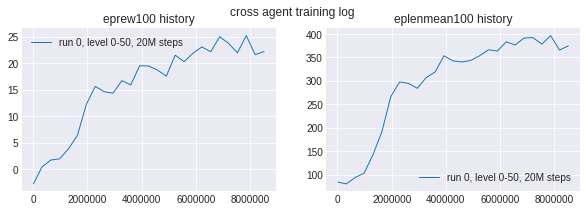

In [34]:
agent = "cross"
log_dir='log/{}/train'.format(agent)
keys=['eprew100', 'eplenmean100']
title="{} agent training log".format(agent)
plot_compare_runs(log_dir=log_dir, run_ids=run_ids, keys=keys, title=title)

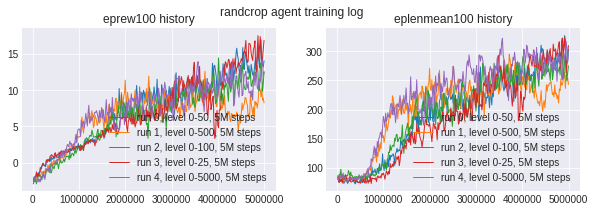

In [24]:
plot_compare_runs(\
                  log_dir='log/randcrop/train', run_ids=[0,1,2,3,4], 
                  keys=['eprew100', 'eplenmean100'], title="randcrop agent training log")

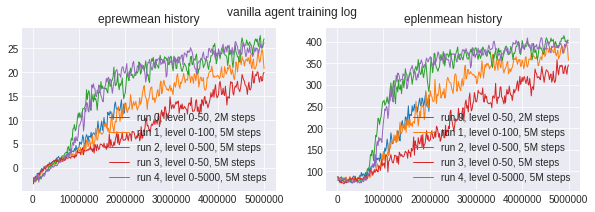

In [25]:
agent = "vanilla"
log_dir='log/{}/train'.format(agent)
run_ids= range(5)
keys=['eprewmean', 'eplenmean']
title="{} agent training log".format(agent)
plot_compare_runs(log_dir=log_dir, run_ids=run_ids, keys=keys, title=title)

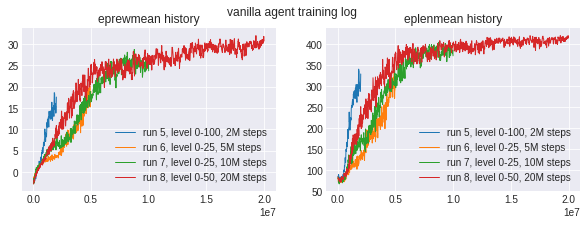

In [26]:
run_ids= range(5,9)
plot_compare_runs(log_dir=log_dir, run_ids=run_ids, keys=keys, title=title)

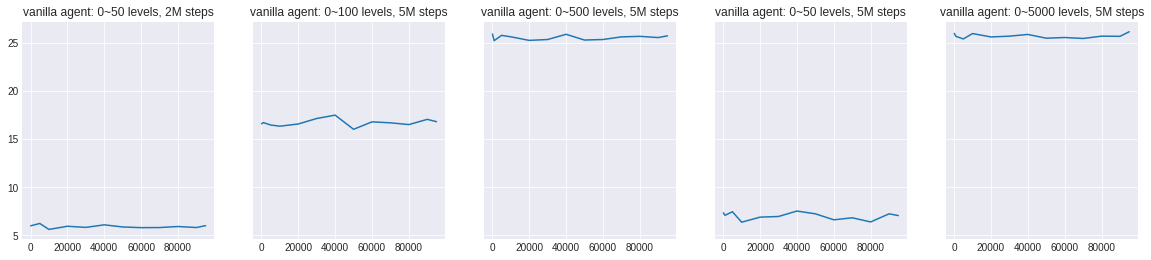

In [27]:
agents = ["vanilla"]*5
ids = [i for i in range(5)]
compare_test(agents, ids)

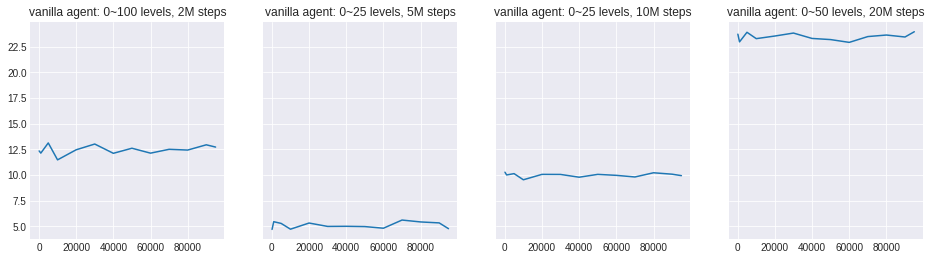

In [22]:
agents = ["vanilla"]*5
ids = [i for i in range(5,9)]
compare_test(agents, ids)

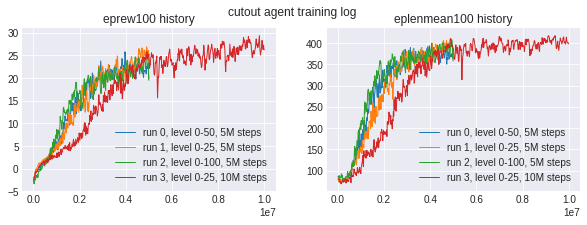

In [28]:
agent = "cutout"
log_dir='log/{}/train'.format(agent)
run_ids= range(4)
keys=['eprew100', 'eplenmean100']
title="{} agent training log".format(agent)
plot_compare_runs(log_dir=log_dir, run_ids=run_ids, keys=keys, title=title)


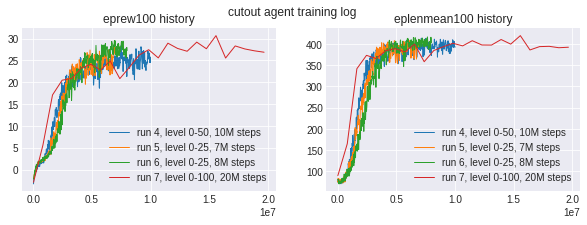

In [29]:
run_ids= range(4,8)
plot_compare_runs(log_dir=log_dir, run_ids=run_ids, keys=keys, title=title)


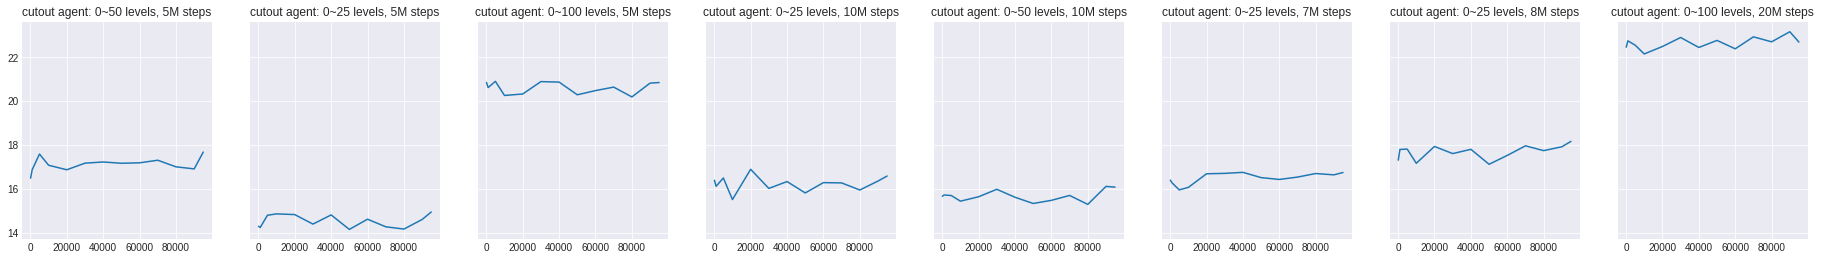

In [10]:
agents = ["cutout"]*8
ids = [i for i in range(8)]
compare_test(agents, ids)

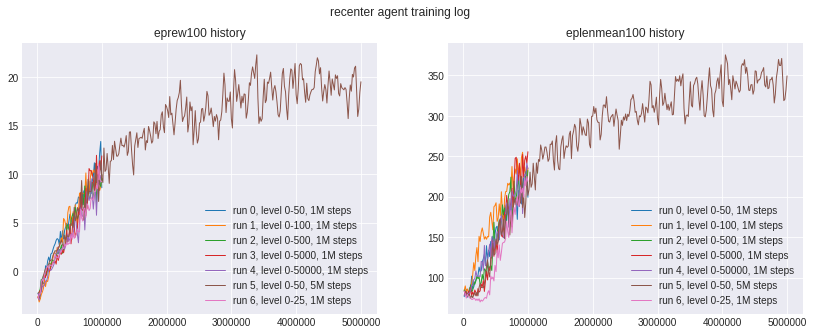

In [203]:
plot_compare_runs(\
                  log_dir='log/recenter/train', run_ids=[0,1,2,3,4,5,6], 
                  keys=['eprew100', 'eplenmean100'], title="recenter agent training log")

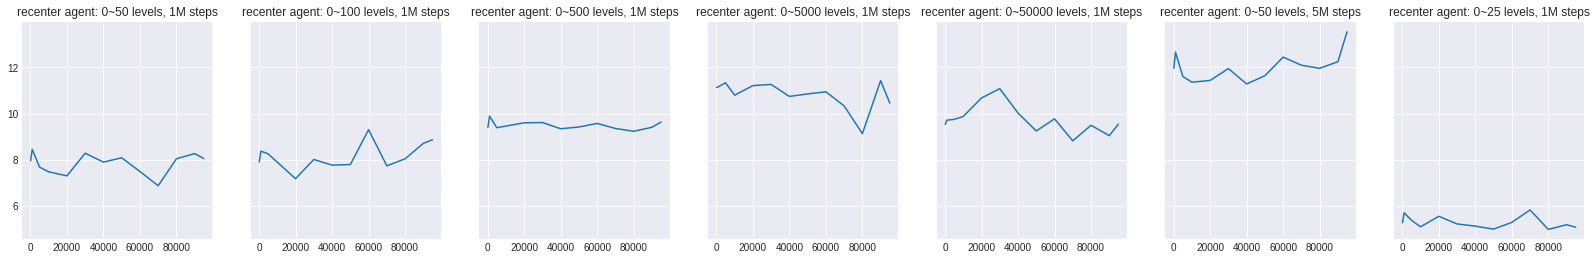

In [304]:
n=7
agents = ["recenter"]*n
ids = [i for i in range(n)]
compare_test(agents, ids)

In [5]:
def plot_test_results(agent="randcrop", load_id=0):
    ## get training info
    jpath = join("log", agent, "train", "args_run_{}.json".format(str(load_id).zfill(2)))
    with open(jpath, 'r') as jfile:
        arg = json.load(jfile)
    
    fig, axs = plt.subplots(1,1, figsize=(8, 3), sharey=True)
    for i in range(13):
        x, y = i//7, i%7
        test_p = join("log", agent, "test", "run_{}_load{}".format(\
                            str(i).zfill(2), str(load_id)))
        
        test_j = join(test_p, "args_run_{}_load{}.json".format(\
                            str(i).zfill(2), str(load_id)))
        with open(test_j, 'r') as test_jfile:
            test_arg = json.load(test_jfile)
        p = join(test_p, "progress.csv")
        df = pd.read_csv(p)
        rew = df["eprew100"].to_numpy()[1:]
        xs = df['misc/total_timesteps'].to_numpy()[1:]
        _mean = np.mean(rew)
        #axs.plot(xs, rew)
        axs.plot(xs, [_mean for x in xs], \
                    label="test on levels {}~{}".format(\
                    str(test_arg["start_level"]), str(test_arg["start_level"]+1000)))
        axs.legend()
    title = "test {} agent trained on 0~{} levels for {}M steps".format(\
             agent, str(arg["num_levels"]), str(arg["total_tsteps"] // int(1e6)))
    fig.suptitle(title)
    plt.show()

In [7]:
TEST = [100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 95000]
    

In [4]:
def compare_test(agents=["randcrop","vanilla"], ids=[0,0]):
    fig, axs = plt.subplots(1,len(ids), figsize=(4*len(ids), 4), sharey=True)
    for agent, load_id, idx in zip(agents, ids, range(len(ids))):
        jpath = join("log", agent, "train", "args_run_{}.json".format(str(load_id).zfill(2)))
        with open(jpath, 'r') as jfile:
            arg = json.load(jfile)
        avg = []
        for i in range(13):
            test_p = join("log", agent, "test", "run_{}_load{}".format(\
                            str(i).zfill(2), str(load_id)) )
            test_j = join(test_p, "args_run_{}_load{}.json".format(\
                            str(i).zfill(2), str(load_id)))
            with open(test_j, 'r') as test_jfile:
                test_arg = json.load(test_jfile)
            p = join(test_p, "progress.csv")
            df = pd.read_csv(p)
            rew = df["eprew100"].to_numpy()[1:]
            _mean = np.mean(rew)
            avg.append(_mean)

        title = "{} agent: 0~{} levels, {}M steps".format(\
             agent, str(arg["num_levels"]), str(arg["total_tsteps"] // int(1e6)))
        axs[idx].plot(TEST, avg)
        axs[idx].set_title(title)
    
    plt.show()

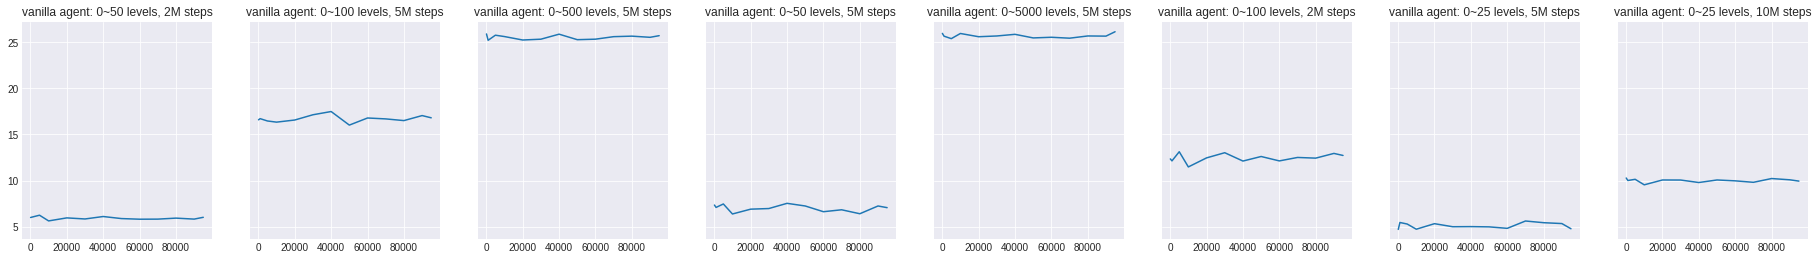

In [219]:
n = 8
agents=["vanilla" for _ in ids]
ids = [i for i in range(n)]
compare_test(agents, ids)

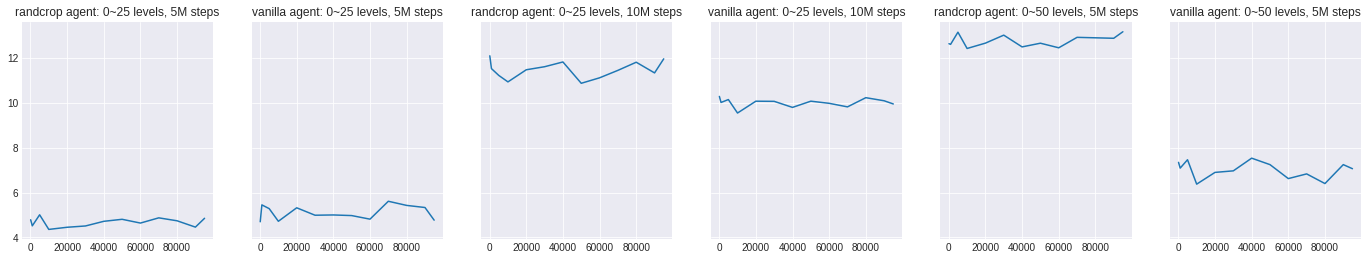

In [216]:
agents = ["randcrop", "vanilla"]*3
ids = [3,6,5,7,0,3]
compare_test(agents, ids)

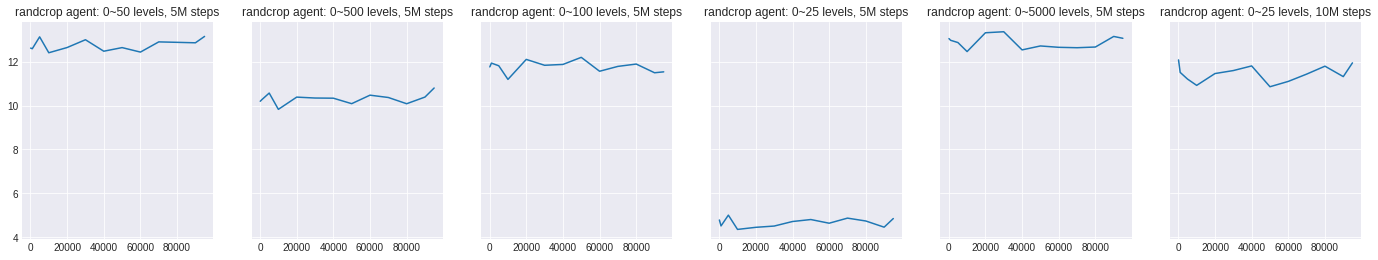

In [213]:
n = 6
agents=["randcrop" for _ in range(n)]
ids = [i for i in range(n)]
compare_test(agents, ids)

#### Below we can see that, training a randcrop agent and baseline agent with same avaliable levels and same training steps, randcrop agent consistently generalizes better

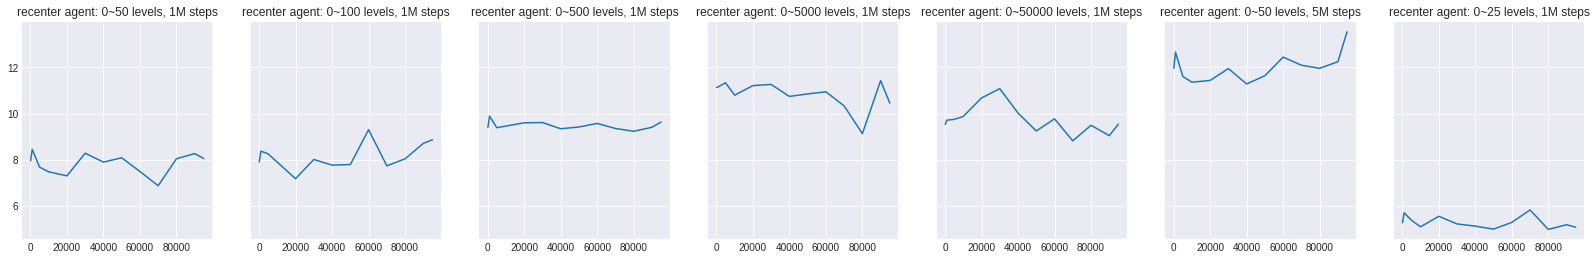

In [220]:
n = 7
agents=["recenter" for _ in range(n)]
ids = [i for i in range(n)]
compare_test(agents, ids)

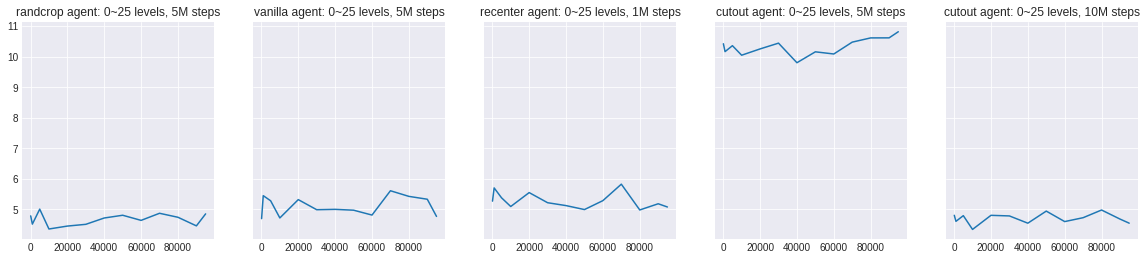

In [273]:
agents = ["randcrop", "vanilla", "recenter", "cutout", "cutout"]
ids = [3,6,6,1,3]
compare_test(agents, ids)

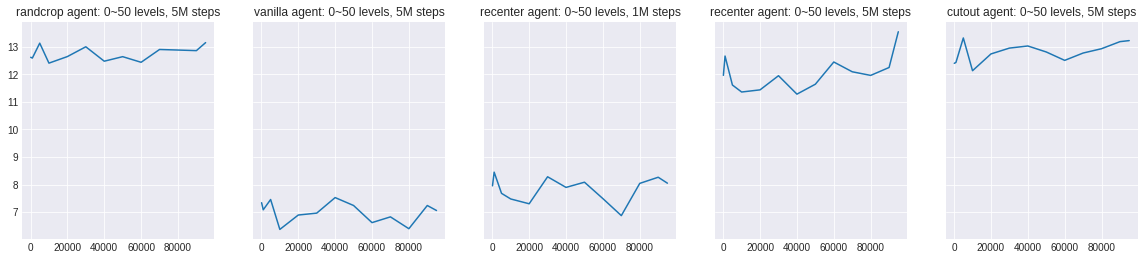

In [241]:
agents = ["randcrop", "vanilla", "recenter", 'recenter', 'cutout']
ids = [0,3,0,5,0]
compare_test(agents, ids)

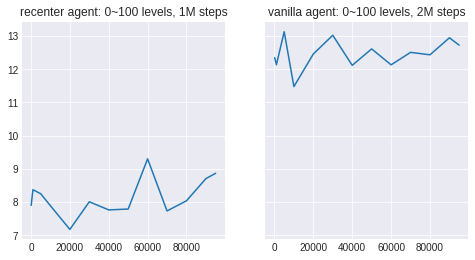

In [221]:
agents = ["recenter", "vanilla"]
ids = [1,5]
compare_test(agents, ids)

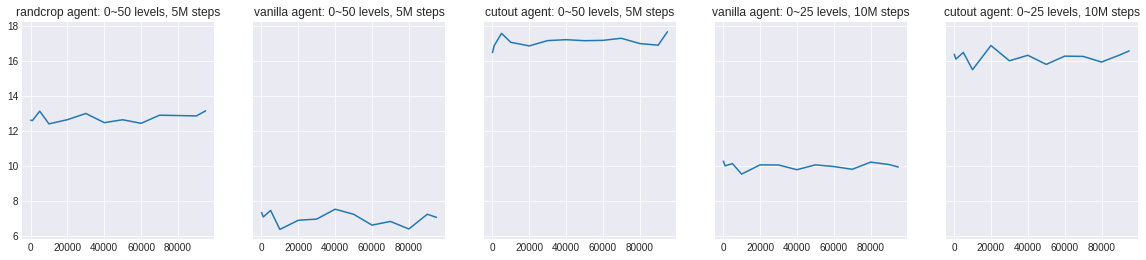

In [11]:
agents = ["randcrop", "vanilla", "cutout", "vanilla", "cutout"]
ids = [0,3,0,7,3]
compare_test(agents, ids)

### Below we can see that recenter agent has better sample efficiency:
50levels + 1M step yields BETTER performance to baseline 50levels+2M steps

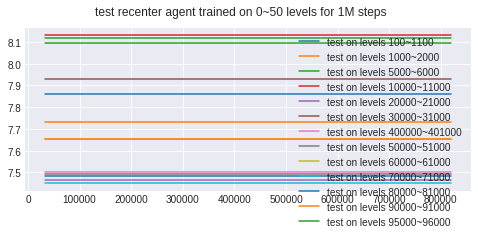

In [139]:
plot_test_results(agent="recenter", load_id=0) ## TODO: train recenter on 25 levels
## TODO: retrain run_id-1

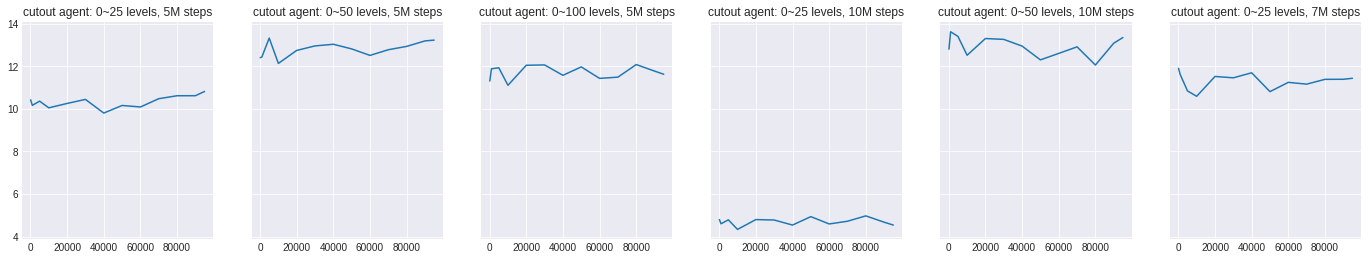

In [282]:
agents = ["cutout"]*6
ids = [1,0,2,3,4,5]
compare_test(agents, ids)

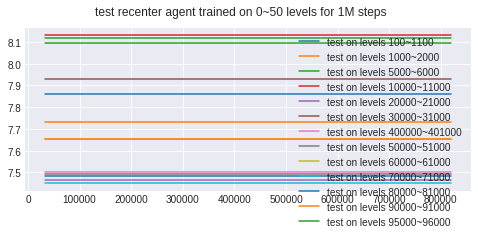

In [101]:
## recenter generlizes well?
plot_test_results(agent="recenter", load_id=0)

In [23]:
def plot_compare_runs(log_dir='log/random/train', run_ids=[0,1], keys=['eprew100', 'eplenmean100'], title="random ppo agent training log"):
    pths = [join(log_dir, "run_"+str(run_id).zfill(2), 'progress.csv') for run_id in run_ids]
    args = [join(log_dir, "args_run_{}.json".format(str(run_id).zfill(2))) for run_id in run_ids]
    fig, axs = plt.subplots(1,len(keys), figsize=(5*len(keys), 3))
    for i in range(len(keys)):
        key = keys[i]
        for p, jpath, run_id in zip(pths, args, run_ids):
            with open(jpath, 'r') as jfile:
                arg = json.load(jfile)
            df = pd.read_csv(p)
            x, y = df['misc/total_timesteps'].to_numpy(), df[key].to_numpy()
            axs[i].plot(x,y, lw=1,\
                        label="run {}, level 0-{}, {}M steps".format(\
                        str(arg["run_id"]), str(arg["num_levels"]),\
                        str(arg["total_tsteps"] // int(1e6))))
        axs[i].set_title("{} history".format(key))
        axs[i].legend()
    fig.suptitle(title)
    plt.show()
    
def plot_compare_agents(log_dirs=['log/random_log/test', 'log/vanilla/test'], \
                        legends=["random agent", "basic agent"],
                        run_ids=[1,1], keys=['eprew100', 'eplenmean'],
                        title="Comparing two agents performance on unseen levels"):
    pths = []
    for i in range(len(log_dirs)):
        pths.append(join(log_dirs[i], "run_"+str(run_ids[i]).zfill(2), 'progress.csv'))
    fig, axs = plt.subplots(1, len(keys), figsize=(7*len(keys), 5))
    for i in range(len(keys)):
        key = keys[i]
        for p in pths:
            df = pd.read_csv(p)
            x, y = df['misc/total_timesteps'].to_numpy(), df[key].to_numpy()
            axs[i].plot(x,y)
        axs[i].legend(legends)
        axs[i].set_title("{} history".format(key))
    fig.suptitle(title)
    plt.show()
# fpath = "log/random/train/args_run_00.json"
# with open(fpath, 'r') as json_file:
#     json_object = json.load(json_file)
# print(json.dumps(json_object, indent=1))

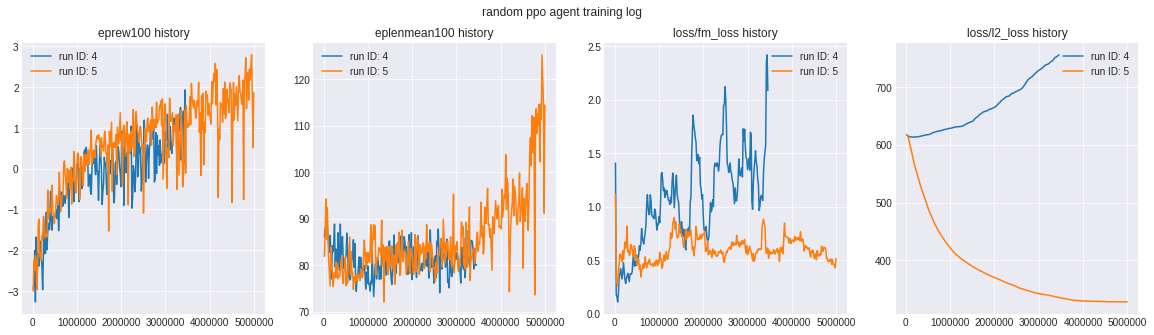

In [408]:
plot_compare_runs(run_ids=[4,5], keys=['eprew100', 'eplenmean100', 'loss/fm_loss', 'loss/l2_loss'])

In [228]:
fpath1, fpath2 = "log/vanilla/test/args_run_02.json", "log/random_log/test/args_run_02.json"
with open(fpath1, 'r') as json_file1:
    json_object1 = json.load(json_file1)
print(json.dumps(json_object1, indent=1))
with open(fpath2, 'r') as json_file2:
    json_object2 = json.load(json_file2)
print(json.dumps(json_object2, indent=1))

{
 "distribution_mode": "easy",
 "env_name": "fruitbot",
 "nrollouts": 50,
 "num_levels": 50,
 "run_id": 2,
 "start_level": 150,
 "total_timesteps": 100000
}
{
 "distribution_mode": "easy",
 "env_name": "fruitbot",
 "nrollouts": 50,
 "num_levels": 50,
 "run_id": 2,
 "start_level": 150,
 "total_timesteps": 100000
}


In [259]:
json_object1["start_level"]

150

### Some visualization on how I recentered the frames

In [223]:
obs = []
name = "obs_env"
for i in range(3, 10):
    obs.append(plt.imread(name+str(i)+".jpg"))
len(obs)

7

In [225]:
from scipy import ndimage
ret = ndimage.gaussian_gradient_magnitude(obs[0], sigma=3)

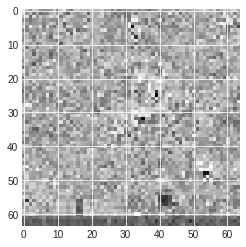

In [316]:
ret = obs[0].copy()
plt.imshow(ret[:,:,0])

In [330]:
img[20,40]

0.6894674509803922

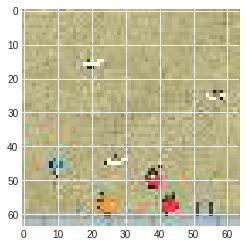

In [332]:
plt.imshow(img)

In [331]:
from skimage import io
img = io.imread("obs_env4.jpg", as_gray=True)

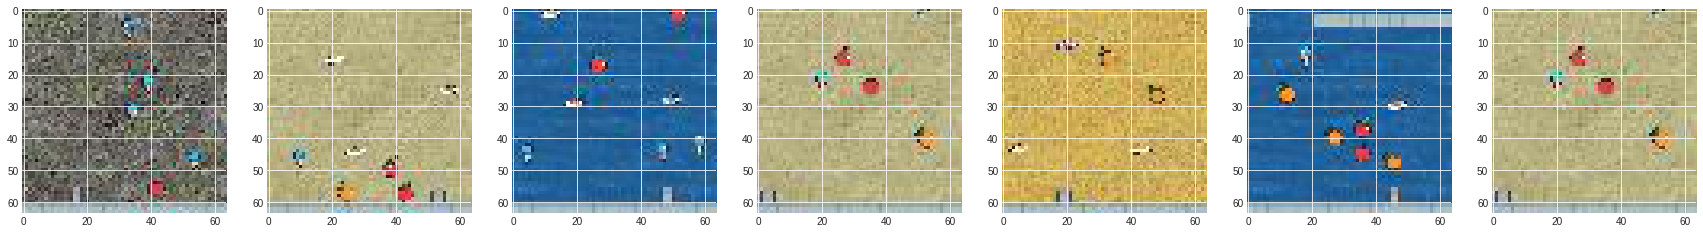

In [11]:
fig, axs = plt.subplots(1, len(obs), figsize=(30, 30*len(obs)))
for i in range(len(obs)):
    axs[i].imshow(obs[i])

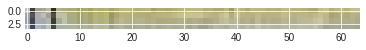

In [108]:
piece = obs[-1][:][57:57+4][:]
plt.imshow(piece)

In [109]:
piece.shape
piece = np.transpose(piece, (1,0,2))

In [110]:
bot = piece[2:5]
bot = np.transpose(bot, (1,0,2))

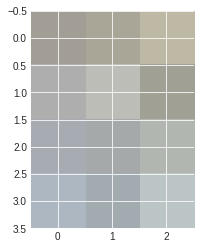

In [119]:
plt.imshow(bot) ## Target pixel values!! (4,5,3)

In [112]:
bot.shape

(4, 3, 3)

In [120]:
bot_norm = bot / np.linalg.norm(bot) ## Not hard-coded as global var!

In [179]:
def recenter(obs, bot_norm):
    recentered = []
    for i in range(obs.shape[0]): ## iterate through envs
        one_obs = obs[i]
        piece = np.transpose(one_obs[:][57:57+4][:], (1,0,2))
        bg = np.zeros((64*2, 64, 3), dtype=np.uint8)
        diff_min = 100
        loc_min = -1
        for loc in range(64-3):
            block = piece[loc:loc+3]
            block = np.transpose(block, (1,0,2))
            diff = abs(np.sum(bot_norm - block/np.linalg.norm(block)))
            if diff < diff_min:
                diff_min = diff
                loc_min = loc
        blk = piece[loc_min:loc_min+3]
        #print("detected loc: ", loc_min)
        center = 62 - loc_min
        bg[center:center+64] = one_obs.transpose((1,0,2))
        recentered.append(bg.transpose((1,0,2)))
    recentered = np.array(recentered)
    return recentered
    

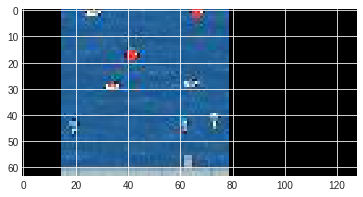

In [182]:
recentered = recenter(obs, bot_norm)
plt.imshow(recentered[2])

In [188]:
recentered[2].shape

(64, 128, 3)